# XGBoost Model Performance Evaluation and Learning Curve Analysis

训练集RMSE: 0.17617969514357357
验证集RMSE: 8.588950078394493
测试集RMSE: 8.03843060332881
训练集R²: 0.999658813050585
验证集R²: 0.28249453132957514
测试集R²: 0.16062446586717694


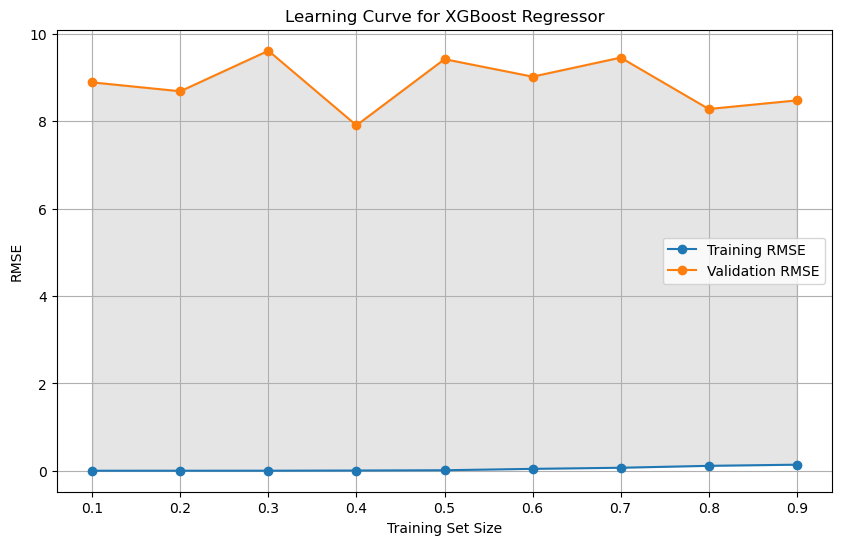

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Load data from the relative directory
file_path = "./SHAP/Sample.csv"
df = pd.read_csv(file_path)

# Separate independent variables, control variables, and dependent variable
X = df.iloc[:, :4]  # The first four columns are independent variables
control = df.iloc[:, 4:7]  # The next three columns are control variables
y = df.iloc[:, -1]  # The last column is the dependent variable (target)

# Combine independent variables and control variables
X_full = pd.concat([X, control], axis=1)

# Step 1: Remove outliers
# Using z-score to detect and remove outliers based on a threshold
z_scores = np.abs(zscore(X_full))
threshold = 3  # Set the z-score threshold; values above this are considered outliers
X_filtered = X_full[(z_scores < threshold).all(axis=1)]
y_filtered = y[(z_scores < threshold).all(axis=1)]

# Step 2: Split the data into training set (70%), test set (20%), and validation set (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # 0.33 * 0.3 ≈ 0.1

# Step 3: Define XGBoost and parameter grid for GridSearchCV
# Initialize the XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', seed=42)

# Define a parameter grid for GridSearchCV with 8 values for each parameter
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.65, 0.75],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.65, 0.75],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
}

# Use GridSearchCV to automatically search for the best hyperparameters
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Extract the best model from grid search
best_xgb = grid_search.best_estimator_

# Step 4: Model performance evaluation
# Predict target values for training, validation, and test sets using the best model
y_train_pred = best_xgb.predict(X_train)
y_val_pred = best_xgb.predict(X_val)
y_test_pred = best_xgb.predict(X_test)

# Calculate RMSE and R² scores for performance evaluation
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results of the model's performance metrics and best parameters
print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print(f"Training RMSE: {train_rmse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training R²: {train_r2}")
print(f"Validation R²: {val_r2}")
print(f"Test R²: {test_r2}")

# Step 5: Plot the learning curve
train_sizes = np.linspace(0.1, 0.9, 9)  # Define a range of training set sizes to avoid reaching 1.0
train_errors = []
val_errors = []

# Evaluate model performance for different training set sizes
for train_size in train_sizes:
    X_partial, _, y_partial, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
    best_xgb.fit(X_partial, y_partial)
    y_partial_train_pred = best_xgb.predict(X_partial)
    y_partial_val_pred = best_xgb.predict(X_val)
    train_errors.append(mean_squared_error(y_partial, y_partial_train_pred, squared=False))
    val_errors.append(mean_squared_error(y_val, y_partial_val_pred, squared=False))

# Plot the learning curve to visualize training vs. validation performance
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Training RMSE', marker='o', linestyle='-')
plt.plot(train_sizes, val_errors, label='Validation RMSE', marker='o', linestyle='-')
plt.fill_between(train_sizes, train_errors, val_errors, color="gray", alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve for XGBoost Regressor with Optimal Parameters")
plt.legend(loc="best")
plt.grid()
plt.show()


# Feature Importance and Non-linear Effects of Predictors on Target Variable Using SHAP

[17:28:03] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


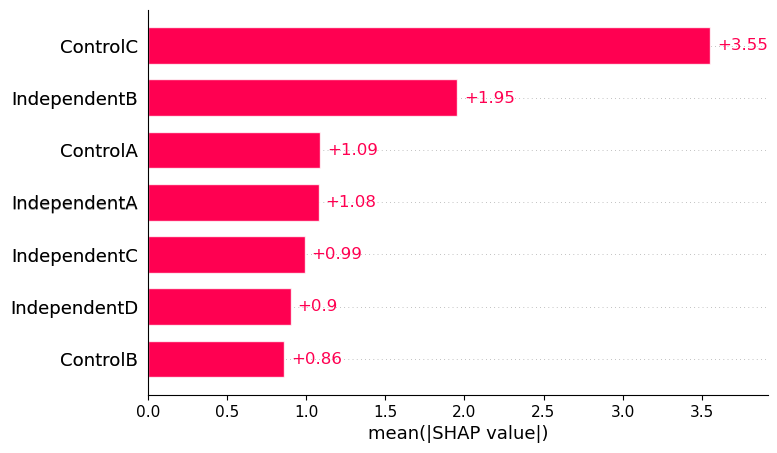

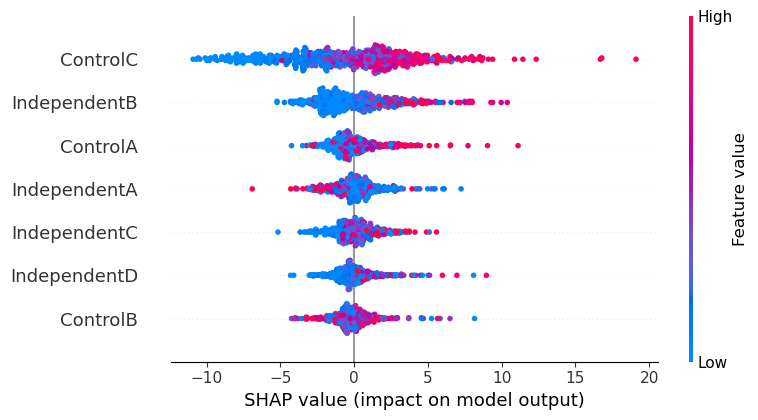

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from scipy.stats import zscore
import shap
import matplotlib.pyplot as plt

# Load data from the relative directory
file_path = "./SHAP/Sample.csv"
df = pd.read_csv(file_path)

# Separate independent variables, control variables, and dependent variable
X = df.iloc[:, :4]  # The first four columns are independent variables
control = df.iloc[:, 4:7]  # The next three columns are control variables
y = df.iloc[:, -1]  # The last column is the dependent variable (target)

# Combine independent variables and control variables
X_full = pd.concat([X, control], axis=1)

# Step 1: Remove outliers
# Using z-score to detect and remove outliers based on a threshold
z_scores = np.abs(zscore(X_full))
threshold = 3  # Set the z-score threshold; values above this are considered outliers
X_filtered = X_full[(z_scores < threshold).all(axis=1)]
y_filtered = y[(z_scores < threshold).all(axis=1)]

# Step 2: Split the data into training set (70%), test set (20%), and validation set (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # 0.33 * 0.3 ≈ 0.1

# Step 3: Train the XGBoost model
# Using default parameters for the XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', seed=42)
xgb.fit(X_train, y_train)

# Step 4: Use SHAP to interpret the model and generate visualizations
# Create a SHAP explainer to analyze the model's feature importance
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

# Generate SHAP feature importance bar plot
plt.figure(figsize=(10, 6))
shap.plots.bar(shap_values, show=False)  # Display the SHAP feature importance bar plot

# Generate SHAP summary dot plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, plot_type="dot", show=False)  # Display the SHAP summary dot plot

# Show the plots
plt.show()


# Non-linear Relationship Analysis Between Each Predictor and the Target Variable

[17:14:01] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[17:14:02] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


<Figure size 1000x600 with 0 Axes>

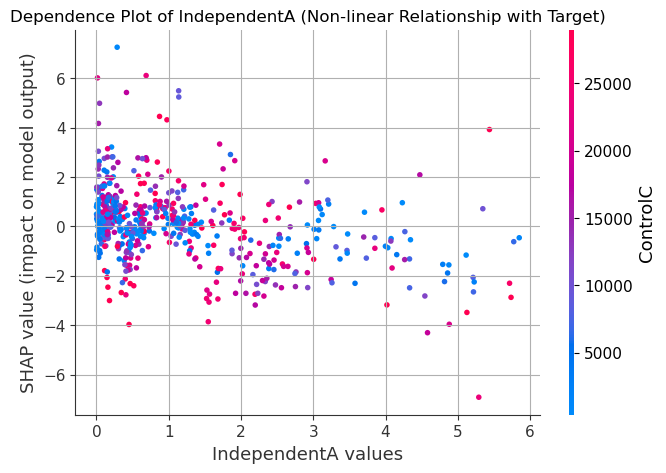

<Figure size 1000x600 with 0 Axes>

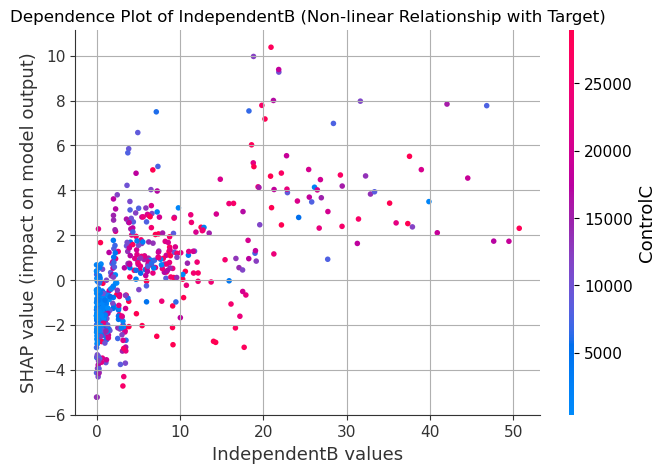

<Figure size 1000x600 with 0 Axes>

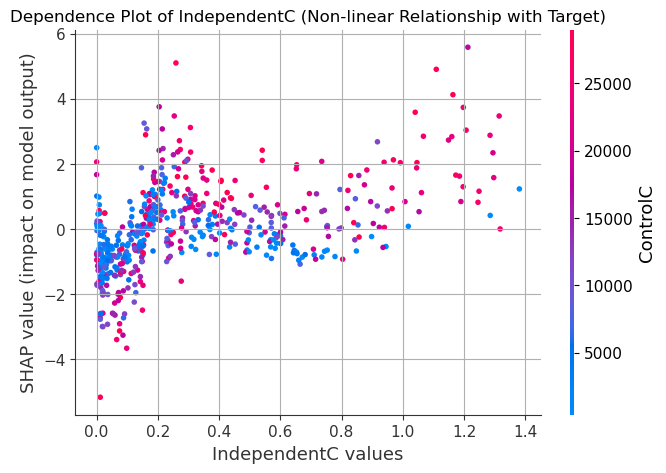

<Figure size 1000x600 with 0 Axes>

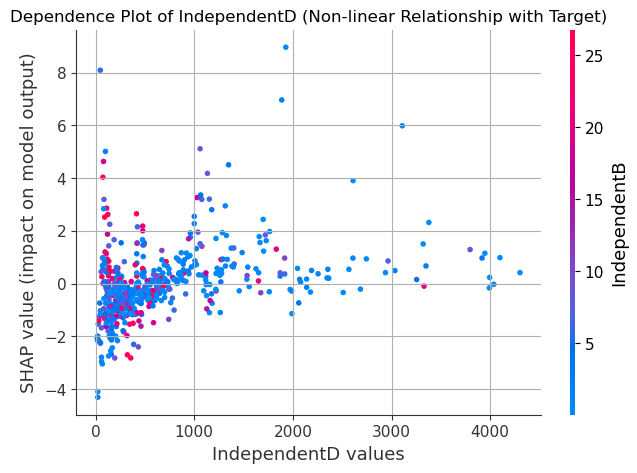

<Figure size 1000x600 with 0 Axes>

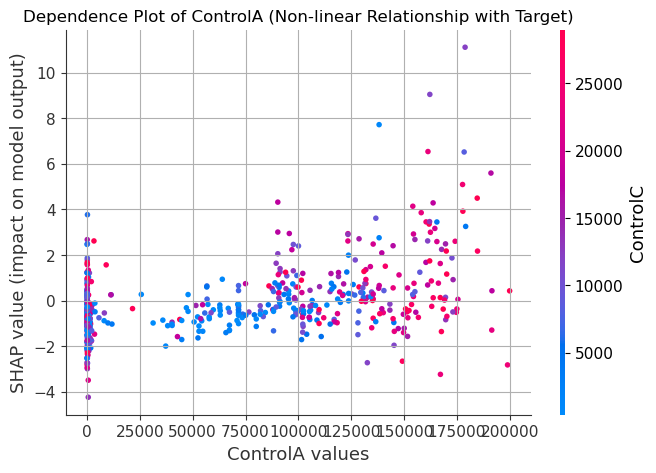

<Figure size 1000x600 with 0 Axes>

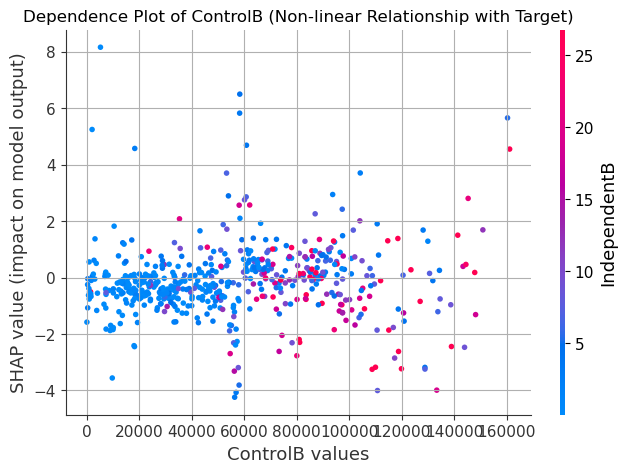

<Figure size 1000x600 with 0 Axes>

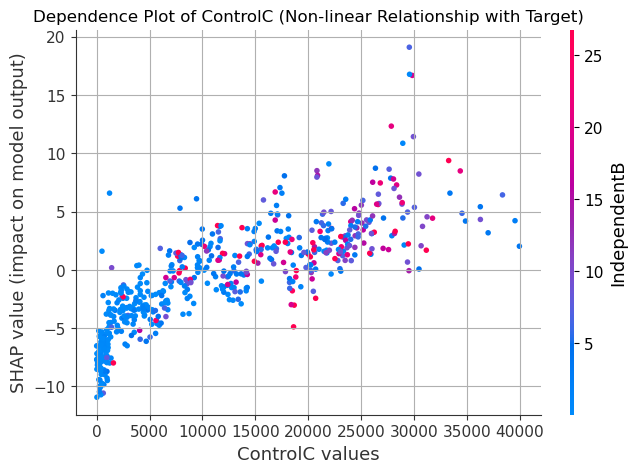

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from scipy.stats import zscore
import shap
import matplotlib.pyplot as plt

# Load data from the relative directory
file_path = "./SHAP/Sample.csv"
df = pd.read_csv(file_path)

# Separate independent variables, control variables, and dependent variable
X = df.iloc[:, :4]  # The first four columns are independent variables
control = df.iloc[:, 4:7]  # The next three columns are control variables
y = df.iloc[:, -1]  # The last column is the dependent variable (target)

# Combine independent variables and control variables
X_full = pd.concat([X, control], axis=1)

# Step 1: Remove outliers
# Using z-score to detect and remove outliers based on a threshold
z_scores = np.abs(zscore(X_full))
threshold = 3  # Set the z-score threshold; values above this are considered outliers
X_filtered = X_full[(z_scores < threshold).all(axis=1)]
y_filtered = y[(z_scores < threshold).all(axis=1)]

# Step 2: Split the data into training set (70%), test set (20%), and validation set (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # 0.33 * 0.3 ≈ 0.1

# Step 3: Train the XGBoost model
# Using default parameters for the XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', seed=42)
xgb.fit(X_train, y_train)

# Step 4: Use SHAP to interpret the model and generate dependence plots
# Create a SHAP explainer to analyze the model's feature importance
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

# Step 5: Plot non-linear relationship (dependence) for each feature
# Generate a dependence plot for each feature to visualize non-linear relationships
for feature in X_train.columns:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values.values, X_train, show=False)
    plt.title(f"Dependence Plot of {feature} (Non-linear Relationship with Target)")
    plt.xlabel(f"{feature} values")
    plt.ylabel("SHAP value (impact on model output)")
    plt.grid(True)
    plt.show()


# Local Feature Contributions for a Single Prediction Using SHAP

[17:18:16] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


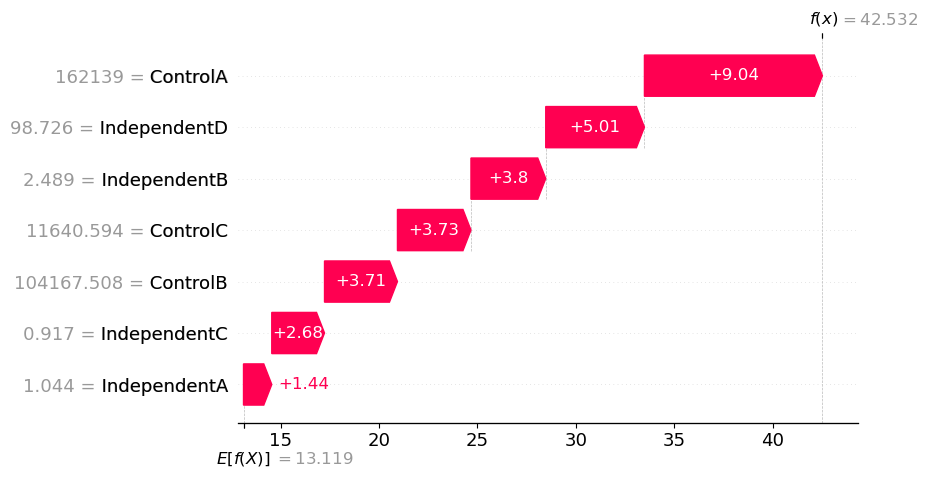

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from scipy.stats import zscore
import shap
import matplotlib.pyplot as plt

# Load data from the relative directory
file_path = "./SHAP/Sample.csv"
df = pd.read_csv(file_path)

# Separate independent variables, control variables, and dependent variable
X = df.iloc[:, :4]  # The first four columns are independent variables
control = df.iloc[:, 4:7]  # The next three columns are control variables
y = df.iloc[:, -1]  # The last column is the dependent variable (target)

# Combine independent variables and control variables
X_full = pd.concat([X, control], axis=1)

# Step 1: Remove outliers
# Using z-score to detect and remove outliers based on a threshold
z_scores = np.abs(zscore(X_full))
threshold = 3  # Set the z-score threshold; values above this are considered outliers
X_filtered = X_full[(z_scores < threshold).all(axis=1)]
y_filtered = y[(z_scores < threshold).all(axis=1)]

# Step 2: Split the data into training set (70%), test set (20%), and validation set (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # 0.33 * 0.3 ≈ 0.1

# Step 3: Train the XGBoost model
# Using default parameters for the XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', seed=42)
xgb.fit(X_train, y_train)

# Step 4: Use SHAP to interpret the model
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

# Step 5: Plot the local bar chart (waterfall plot) for a specific sample
# Select the sample to explain, for example, the first sample
sample_index = 0
shap.waterfall_plot(shap.Explanation(values=shap_values.values[sample_index], 
                                     base_values=explainer.expected_value, 
                                     data=X_train.iloc[sample_index, :]))


# Feature Contributions for a Single Prediction Using SHAP Force Plot

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from scipy.stats import zscore
import shap
import matplotlib.pyplot as plt

# Load data from the relative directory
file_path = "./SHAP/Sample.csv"
df = pd.read_csv(file_path)

# Separate independent variables, control variables, and dependent variable
X = df.iloc[:, :4]  # The first four columns are independent variables
control = df.iloc[:, 4:7]  # The next three columns are control variables
y = df.iloc[:, -1]  # The last column is the dependent variable (target)

# Combine independent variables and control variables
X_full = pd.concat([X, control], axis=1)

# Step 1: Remove outliers
# Using z-score to detect and remove outliers based on a threshold
z_scores = np.abs(zscore(X_full))
threshold = 3  # Set the z-score threshold; values above this are considered outliers
X_filtered = X_full[(z_scores < threshold).all(axis=1)]
y_filtered = y[(z_scores < threshold).all(axis=1)]

# Step 2: Split the data into training set (70%), test set (20%), and validation set (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # 0.33 * 0.3 ≈ 0.1

# Step 3: Train the XGBoost model
# Using default parameters for the XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', seed=42)
xgb.fit(X_train, y_train)

# Step 4: Use SHAP to interpret the model
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

# Step 5: Plot SHAP Force Plot
# Select the sample to explain, for example, the first sample
sample_index = 0
shap.initjs()  # Initialize JavaScript support for Jupyter Notebook environment
shap.force_plot(explainer.expected_value, shap_values.values[sample_index], X_train.iloc[sample_index, :])


[17:19:14] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


# SHAP Decision Plot: Cumulative Feature Contributions for Selected Predictions

[17:20:31] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


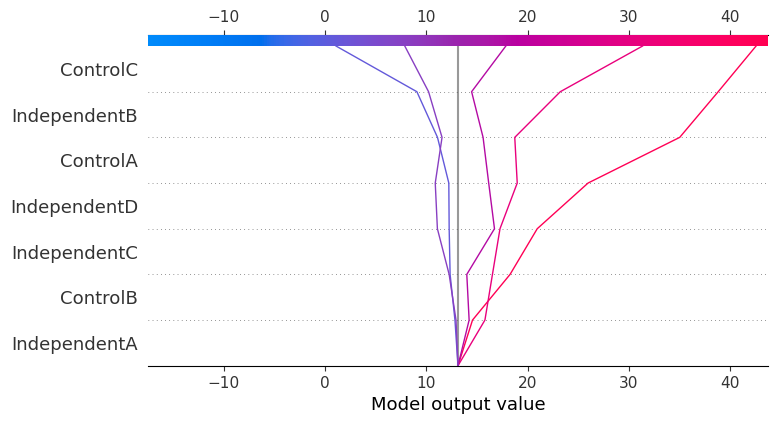

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from scipy.stats import zscore
import shap
import matplotlib.pyplot as plt

# Load data from the relative directory
file_path = "./SHAP/Sample.csv"
df = pd.read_csv(file_path)

# Separate independent variables, control variables, and dependent variable
X = df.iloc[:, :4]  # The first four columns are independent variables
control = df.iloc[:, 4:7]  # The next three columns are control variables
y = df.iloc[:, -1]  # The last column is the dependent variable (target)

# Combine independent variables and control variables
X_full = pd.concat([X, control], axis=1)

# Step 1: Remove outliers
# Using z-score to detect and remove outliers based on a threshold
z_scores = np.abs(zscore(X_full))
threshold = 3  # Set the z-score threshold; values above this are considered outliers
X_filtered = X_full[(z_scores < threshold).all(axis=1)]
y_filtered = y[(z_scores < threshold).all(axis=1)]

# Step 2: Split the data into training set (70%), test set (20%), and validation set (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # 0.33 * 0.3 ≈ 0.1

# Step 3: Train the XGBoost model
# Using default parameters for the XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', seed=42)
xgb.fit(X_train, y_train)

# Step 4: Use SHAP to interpret the model
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

# Step 5: Plot SHAP Decision Plot
# Select multiple samples to explain, for example, the first five samples
sample_indices = range(5)
shap.decision_plot(explainer.expected_value, shap_values.values[sample_indices], X_train.iloc[sample_indices, :])


# SHAP Heatmap Plot: Feature Contributions Across Multiple Predictions

[17:21:35] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


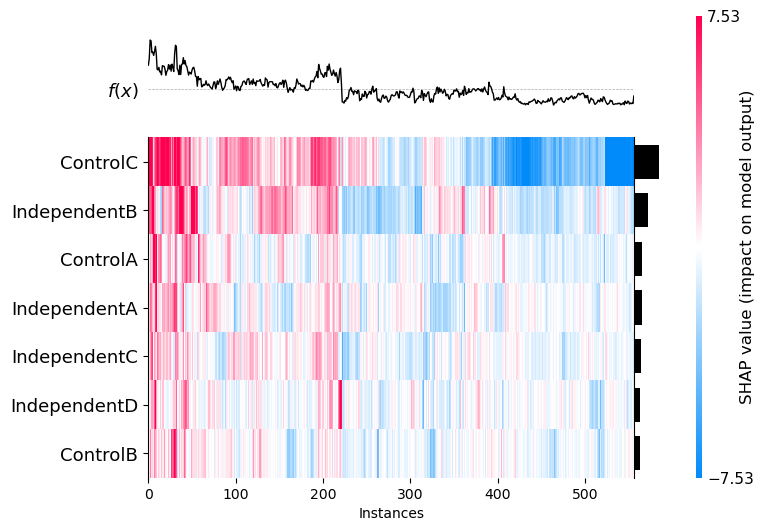

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from scipy.stats import zscore
import shap
import matplotlib.pyplot as plt

# Load data from the relative directory
file_path = "./SHAP/Sample.csv"
df = pd.read_csv(file_path)

# Separate independent variables, control variables, and dependent variable
X = df.iloc[:, :4]  # The first four columns are independent variables
control = df.iloc[:, 4:7]  # The next three columns are control variables
y = df.iloc[:, -1]  # The last column is the dependent variable (target)

# Combine independent variables and control variables
X_full = pd.concat([X, control], axis=1)

# Step 1: Remove outliers
# Using z-score to detect and remove outliers based on a threshold
z_scores = np.abs(zscore(X_full))
threshold = 3  # Set the z-score threshold; values above this are considered outliers
X_filtered = X_full[(z_scores < threshold).all(axis=1)]
y_filtered = y[(z_scores < threshold).all(axis=1)]

# Step 2: Split the data into training set (70%), test set (20%), and validation set (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # 0.33 * 0.3 ≈ 0.1

# Step 3: Train the XGBoost model
# Using default parameters for the XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', seed=42)
xgb.fit(X_train, y_train)

# Step 4: Use SHAP to interpret the model
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

# Step 5: Plot SHAP Heatmap Plot
# Display SHAP heatmap showing feature impact distribution across all samples
shap.plots.heatmap(shap_values, max_display=10)
